# Create population masks for regions

In [1]:
import xarray as xr
import numpy as np
from pyproj import Transformer

## For Australia

From https://www.abs.gov.au/statistics/people/population/regional-population/2021-22#cite-window1 (Australian population grid 2022 in GeoTIFF format) [Accessed 06/07/2023]

In [12]:
# Open tif and drop band dimension
pop = xr.open_rasterio(
    "/g/data/w42/dr6273/work/data/ABS/apg22r_1_0_0.tif",
    # parse_coordinates=False,
).squeeze("band", drop=True)

/jobfs/89808957.gadi-pbs/ipykernel_1142894/3537886820.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  pop = xr.open_rasterio(


In [3]:
pop

<xarray.DataArray (y: 4100, x: 7401)>
[30344100 values with dtype=float32]
Coordinates:
  * y        (y) float64 -1e+06 -1.002e+06 -1.002e+06 ... -5.098e+06 -5.1e+06
  * x        (x) float64 -3.9e+06 -3.9e+06 -3.898e+06 ... 3.498e+06 3.5e+06
Attributes:
    transform:      (1000.0, 0.0, -3901000.0, 0.0, -1000.0, -1000000.0)
    crs:            +init=epsg:3577
    res:            (1000.0, 1000.0)
    is_tiled:       1
    nodatavals:     (-1.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('Band_1',)
    AREA_OR_POINT:  Area

Ocean cells are masked with -1, and many land cells are 0 (no population density). To check what we have is sensible, set the scale max to 3:

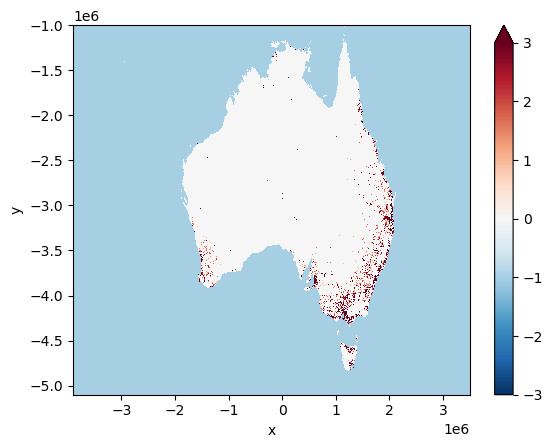

In [7]:
pop.plot.imshow(vmax=3)

According to the attributes, this raster is in the coordinate system EPSG:3577, which in in metres: https://epsg.io/3577

We want to transform to EPSG:4326, which is in lat/lon: https://epsg.io/4326

In [8]:
transformer = Transformer.from_crs("EPSG:3577", "EPSG:4326", always_xy=True)

Apply the transformation - this takes quite a bit of time, so first reduce the size of the array using `.sel` with trial and error of the values, to get as close to Australia as possible.

In [21]:
# pop = pop.isel(
#     x=range(1950, 6050),
#     y=range(100, 3900)
# )
subset = pop.isel(
    x=range(4500, 5500),
    y=range(2500, 4000)
)

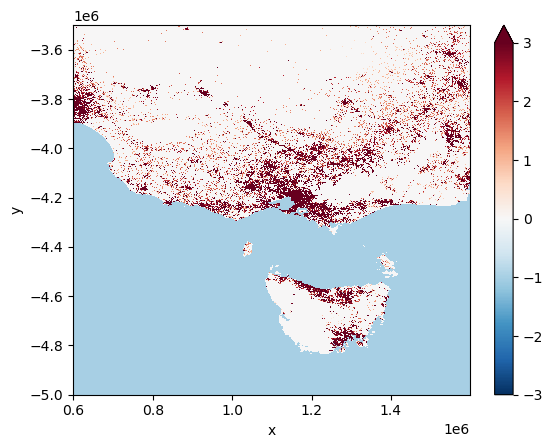

In [22]:
subset.plot.imshow(vmax=3)

In [23]:
# Create rectangular grid
X, Y = np.meshgrid(subset.x.values, subset.y.values)

In [24]:
# We have gone from a 4100x7401 grid to 3800x4100
print(X.shape, Y.shape)

(1500, 1000) (1500, 1000)


In [42]:
%%time
lon, lat = transformer.transform(X, Y)

CPU times: user 1.11 s, sys: 298 ms, total: 1.4 s
Wall time: 3.44 s


In [43]:
subset.coords['lat'] = (subset.dims, lat)
subset.coords['lon'] = (subset.dims, lon)

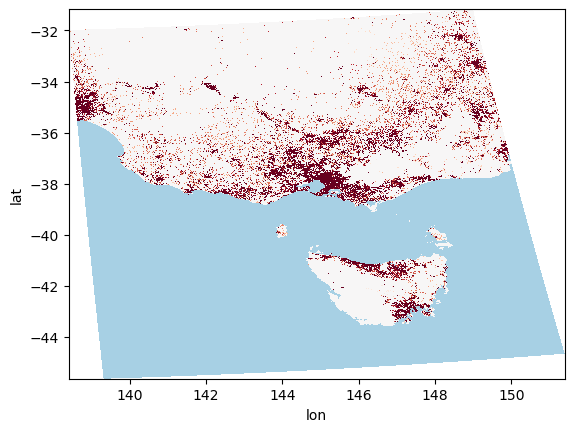

In [47]:
subset.plot.pcolormesh('lon', 'lat', add_colorbar=False, vmax=3)